# Digital Image Processing<br> Problem 8<br> Felix Neutatz

##Morpholigical Processing

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from functools import partial
from random import randint

In [3]:
def plotGreyImage(imageToPlot, title):
    plt.imshow(imageToPlot, cmap='gray') #Greys_r
    plt.title(title)
    plt.axis('off')
    plt.show()

### (a). Implement the morphological operations: erosion, dilation, opening and closing.

In [4]:
def zero_padding(img, pixels):
    padding = np.zeros((img.shape[0] + pixels*2, img.shape[1] + pixels*2))
    
    padding[pixels:(img.shape[0]+pixels),pixels:(img.shape[1]+pixels)] = img
    
    return padding

In [5]:
def crop_image(img, pixels):
    return(img[ pixels:(img.shape[0]-pixels),pixels:(img.shape[1]-pixels) ])

In [50]:
def erosion(A, B):
    
    if ((A==B).all()): #return center
        return A[(A.shape[0]-1)/2,(A.shape[1]-1)/2]
    else:
        return 0

In [81]:
def dilation(A, B):   
    
    if ((A==B).any()):
        return 1
    else:
        return A[(A.shape[0]-1)/2,(A.shape[1]-1)/2]

In [33]:
def convolution(image, filter, filter_shape):
    newImage = np.zeros(image.shape)
    
    center = (filter_shape - 1) / 2
    
    #if a element of the window is outside of the border, fill it with zero = zero padding  
    #iterate through picture pixel by pixel
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            
            #compute current window A        
            A = np.zeros(filter_shape)
            for ax in range(filter_shape[0]):
                if (ax - center[0] + x >= 0 and ax - center[0] + x < image.shape[0]):
                    for ay in range(filter_shape[1]):
                        if (ay - center[1] + y >= 0 and ay - center[1] + y < image.shape[1]):
                            A[ax,ay] = image[ax - center[0] + x, ay - center[1] + y]
                            
            #apply filter to window of point at (x,y)
            newImage[x,y] = filter(A)
    
    return newImage

In [59]:
def opening(img, B):
    erosion_img = convolution(img, partial(erosion, B = B), np.asarray(B.shape))
    dilation_img = convolution(erosion_img, partial(dilation, B = B), np.asarray(B.shape))
    return dilation_img

In [60]:
def closing(img, B):
    dilation_img = convolution(img, partial(dilation, B = B), np.asarray(B.shape))
    erosion_img = convolution(dilation_img, partial(erosion, B = B), np.asarray(B.shape))
    return erosion_img

In [141]:
def read_binary_image(image_name):
    a = mpimg.imread(image_name)
    
    print a.shape
    
    if (len(a.shape) == 2):
        binary_image = a
        
    if (len(a.shape) == 3):
        binary_image = np.zeros((a.shape[0], a.shape[1]))

        for x in range(a.shape[0]):
            for y in range(a.shape[1]):
                binary_image[x][y] = a[x][y][0]
                
    threshold = np.max(binary_image)    
            
    #thresholding
    binary_image[binary_image<threshold] = 0
    binary_image[binary_image>=threshold] = 1
    
    return binary_image

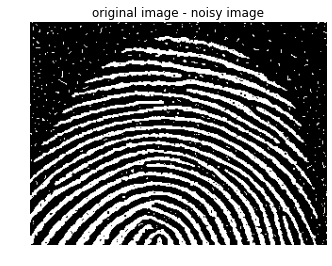

In [70]:
img_fingerprint = 'noisy_fingerprint.tif'
binary_image = read_binary_image(img_fingerprint)
plotGreyImage(binary_image, "original image - noisy image")       


In [71]:
size = 3
B = np.ones((size,size))

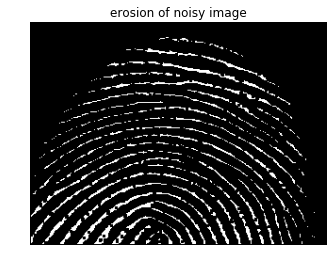

In [72]:
t = convolution(binary_image, partial(erosion, B = B), np.asarray(B.shape))
plotGreyImage(t, "erosion of noisy image")

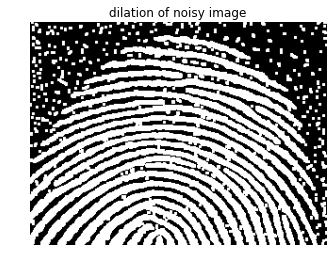

In [73]:
t = convolution(binary_image, partial(dilation, B = B), np.asarray(B.shape))
plotGreyImage(t, "dilation of noisy image")

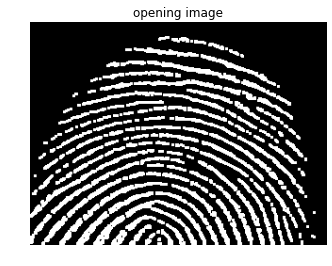

In [61]:
t = opening(binary_image, B)
plotGreyImage(t, "opening of noisy image")

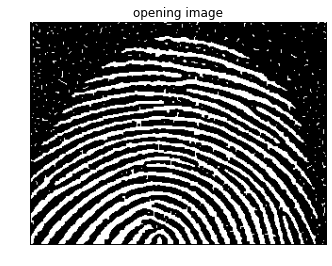

In [62]:
t = closing(binary_image, B)
plotGreyImage(t, "closing of noisy image")

In [82]:
a = binary_image                                                 # noisy image
b = B                                                            # Structuring element
c = convolution(a, partial(erosion, B = b), np.asarray(b.shape)) # eroded image
d = opening(a, b)                                                # opening of A
e = convolution(d, partial(dilation, B = b), np.asarray(b.shape))# dilation of the opening
f = closing(d, b)                                                # closing of the opening

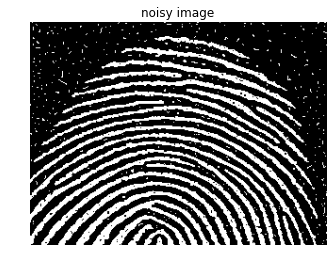

Structuring element[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]


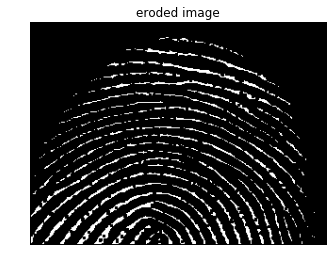

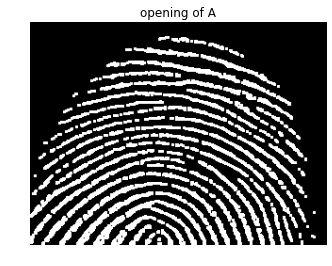

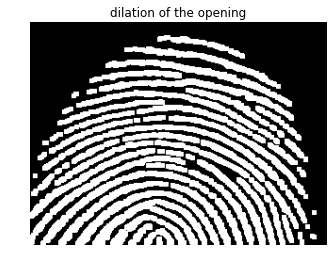

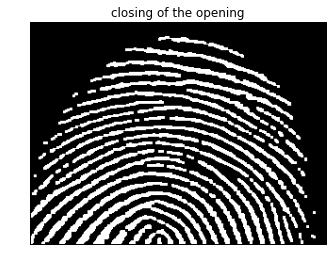

In [83]:
plotGreyImage(a, "noisy image")
print("Structuring element" + str(b))
plotGreyImage(c, "eroded image")
plotGreyImage(d, "opening of A")
plotGreyImage(e, "dilation of the opening")
plotGreyImage(f, "closing of the opening")

### (b). Implement boundary extraction, hole filling, connected component extraction.

In [84]:
def boundary_extraction(img, B):
    erosion_img = convolution(img, partial(erosion, B = B), np.asarray(B.shape))
    return np.logical_and((img == 1), (erosion_img == 0))
    

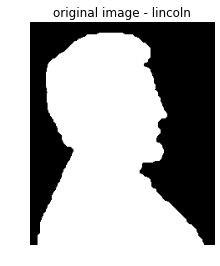

In [85]:
img_lincoln = 'licoln_from_penny.tif'
binary_lincoln = read_binary_image(img_lincoln)
plotGreyImage(binary_lincoln, "original image - lincoln")  

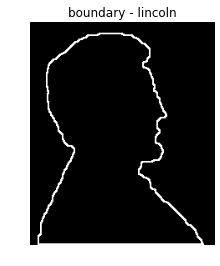

In [86]:
size = 5
B = np.ones((size,size))
boundary = boundary_extraction(binary_lincoln, B)

plotGreyImage(boundary, "boundary - lincoln")  

In [127]:
def filling_holes(img, B):
    I_c = (img == 0)
    
    #border function
    F = np.zeros(img.shape)
    F[0,:] = np.subtract(1, F[0,:])
    F[-1,:] = np.subtract(1, F[-1,:])
    F[1:-1,0] = np.subtract(1, F[1:-1,0])
    F[1:-1,-1] = np.subtract(1, F[1:-1,-1])
    
    print F
    
    
    plotGreyImage(I_c, "i_c / G") #G
    plotGreyImage(F, "F") 
    
    for i in range(5):
    
        #(F⊕B)⋂G
        dilation_img = convolution(F, partial(dilation, B = B), np.asarray(B.shape))
        plotGreyImage(dilation_img, "dilation") 

        F = np.logical_and(dilation_img == 1,I_c)
        plotGreyImage(F, "first") 
    
    
    H = (F==0)
    plotGreyImage(H, "H") 
    
    end = np.logical_and(H, I_c)
    plotGreyImage(end, "end") 
    

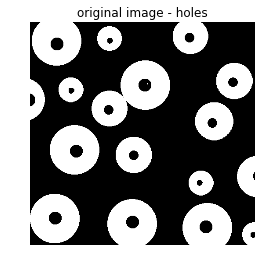

In [95]:
img_holes = 'region_filling_reflections.tif'
binary_holes = read_binary_image(img_holes)
plotGreyImage(binary_holes, "original image - holes") 

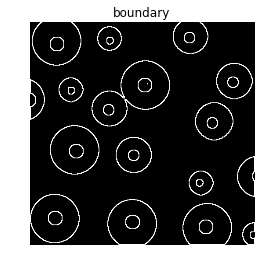

In [96]:
boundary = boundary_extraction(binary_holes, B)

plotGreyImage(boundary, "boundary") 

[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]]


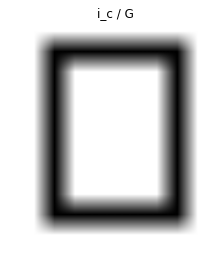

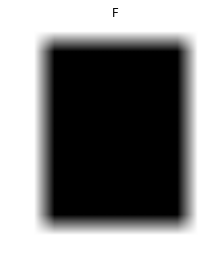

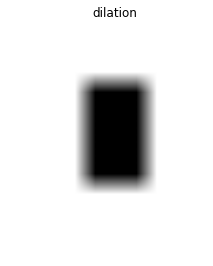

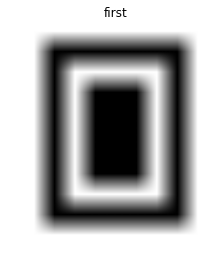

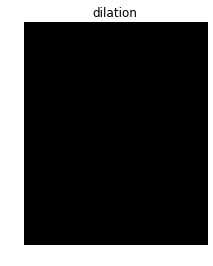

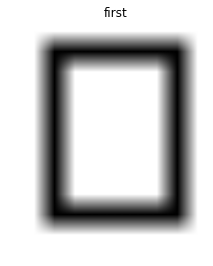

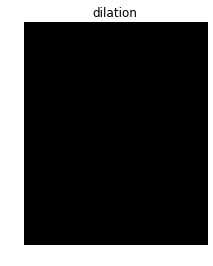

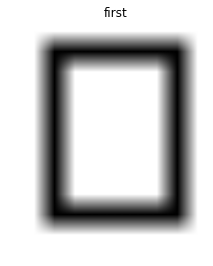

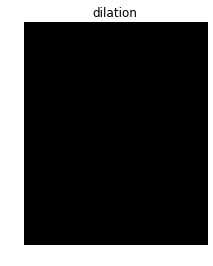

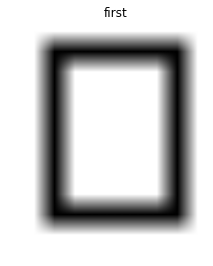

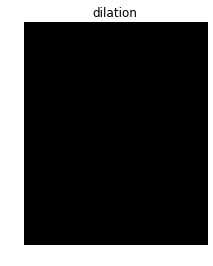

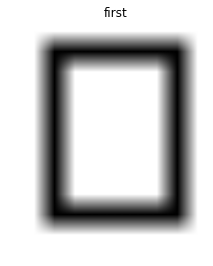

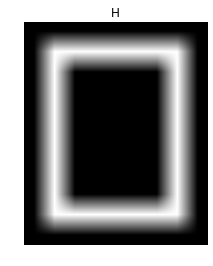

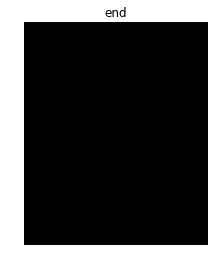

In [128]:
binary_holes = np.matrix ([[0,0,0,0,0,0,0,0,0],
                           [0,1,1,1,1,1,1,1,0],
                           [0,1,0,0,0,0,0,1,0],
                           [0,1,0,0,0,0,0,1,0],
                           [0,1,0,0,0,0,0,1,0],
                           [0,1,0,0,0,0,0,1,0],
                           [0,1,0,0,0,0,0,1,0],
                           [0,1,0,0,0,0,0,1,0],
                           [0,1,0,0,0,0,0,1,0],
                           [0,1,1,1,1,1,1,1,0],
                           [0,0,0,0,0,0,0,0,0],
                          ])


filling_holes(binary_holes, B)

In [148]:
def apply_thresholding(img, T):
    new_img = np.copy(img)
    new_img[img > T] = 1.0
    new_img[img <= T] = 0.0
    
    return new_img    

In [185]:
def connected_components(img, B):
    todo = np.copy(img)
    
    i = 0
    
    for x in range(img.shape[0]):
        for y in range (img.shape[1]):
            if (todo[x,y] == 1):
                X_k = np.zeros(img.shape)
                X_k[x,y] = 1
                
                print X_k
    
                old_X = np.copy(X_k)
                while(True):
                    c = convolution(X_k, partial(dilation, B = B), np.asarray(B.shape)) # eroded image
        
                    print (X_k == True)
            
            
                    X_k = np.logical_and(X_k == True, img == 1)
            
                    if ((X_k == old_X).all()):
                        break
                        
                    old_X = np.copy(X_k)
                
                i += 1
                
                print (str(i) + " component size: " + str(np.sum(X_k)))
                
                todo[X_k] = 0 #delete all elements of component from todo
                print todo
                
                
                
            if(i > 5): break
        if(i > 5): break
        
    plotGreyImage(X_k, "component") 
    
    return X_k
         

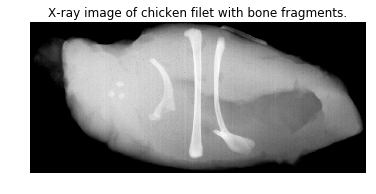

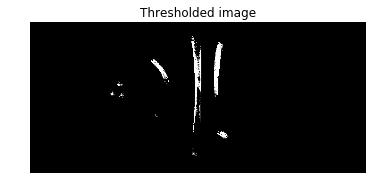

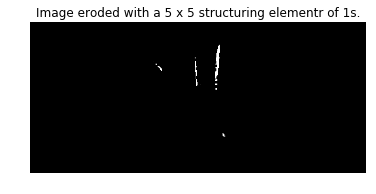

In [164]:
img_bones = 'chickenfilet_with_bones.tif'

a = mpimg.imread(img_bones)
plotGreyImage(a, "X-ray image of chicken filet with bone fragments.") 

segmented = apply_thresholding(a, 210)
plotGreyImage(segmented, "Thresholded image") 

size = 5
B = np.ones((size,size))
c = convolution(segmented, partial(erosion, B = B), np.asarray(B.shape)) # eroded image
plotGreyImage(c, "Image eroded with a 5 x 5 structuring elementr of 1s.") 

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ True False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]
 [False False False False False False False False False]


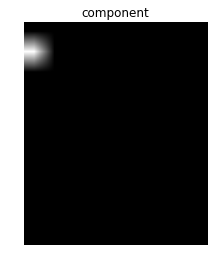

In [187]:
c = np.matrix ([
                           [1,1,1,1,1,0,0,0,0],
                           [1,1,1,1,1,0,0,0,0],
                           [1,1,1,1,1,0,0,0,0],
                           [1,1,1,1,1,0,0,0,0],
                           [0,0,0,0,0,0,1,1,0],
                           [0,0,0,0,0,0,0,0,0],
                           [0,0,0,0,0,0,0,0,0],
                           [0,0,0,1,1,0,0,0,0],
                           [0,0,0,1,1,0,0,0,0],
                           [0,0,0,0,0,0,0,0,0],
                           [0,0,0,0,0,0,0,0,0],
                          ])


size = 3
B = np.ones((size,size)) 
res = connected_components(c, B)

In [173]:
print np.sum(res)

1
